<a href="https://colab.research.google.com/github/johnmcdonnell/CategoryFlashcards/blob/master/Projects/Vivian-Health/notebooks/Finetuning_Model_on_Vivian_Attributes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning a Model to classify Vivian Attributes

Vivian would like to consistently tag its listings with a number of attributes that are described in natural language text. John has used the non-fine-tuned embeddings from sentences combined with some obvious regexes. This works fairly well for "discipline," but isn't really adequate for shift time or specialty.

The idea here is to fine tune a version of BERT to learn the indicators of interest that indicate these categories. This has two potential advantages
1. Increased accuracy
2. Easy portability to other potential Koya clients (if it can be done without too much fussiness)

In [ ]:

!pip install html2text transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.9 MB/s 
     |████████████████████████████████| 365 kB 14.8 MB/s 
     |████████████████████████████████| 6.6 MB 47.9 MB/s 
     |████████████████████████████████| 596 kB 70.9 MB/s 
     |████████████████████████████████| 101 kB 14.2 MB/s 
     |████████████████████████████████| 212 kB 73.7 MB/s 
     |████████████████████████████████| 141 kB 75.6 MB/s 
     |████████████████████████████████| 127 kB 64.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the s

In [ ]:
import os
import numpy as np
import pandas as pd
import html2text

from sklearn.model_selection import train_test_split
import torch
import transformers

import datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Vivian Project'
transformer_dir = '/content/drive/MyDrive/Vivian Project/Transformer Fine Tuning'

Mounted at /content/drive


In [ ]:
print(f"PyTorch version: {torch.__version__}")

print(f"TPU available?: {'COLAB_TPU_ADDR' in os.environ}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")
print(f"Is CUDA available? {torch.cuda.is_available()}")


if 'COLAB_TPU_ADDR' in os.environ:
  # This means we've got a Colab TPU
  # (John was not able to get this running)
  # TPU reference here: https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb
  # Advice here https://github.com/pytorch/xla
  # …and here https://github.com/pytorch/xla/issues/3186
  os.system('pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.11-cp37-cp37m-linux_x86_64.whl')
  import torch_xla.core.xla_model as xm
  device = xm.xla_device()
elif torch.backends.mps.is_available():
  device = "mps"
elif torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"

print(f"Using device: {device}")

PyTorch version: 1.12.0+cu113
TPU available?: False
Is MPS (Metal Performance Shader) built? False
Is MPS available? False
Is CUDA available? True
Using device: cuda


# Prep the data

In [ ]:
job_descriptions = pd.read_csv(f'{data_dir}/tagged_job_descriptions.csv')

# Dropping nan job_ids
job_descriptions = job_descriptions.dropna(subset=['job_id']).set_index('job_id')

In [ ]:
text_maker = html2text.HTML2Text()

def remove_html_tags(string):
    #return BeautifulSoup(string, "lxml").text
    return text_maker.handle(string)


In [ ]:
%%time

def concatenate_title_with_description(row):
    """Concatenates job title with the description, also removes HTML tags from description"""
    if pd.notnull(row['job_title']) and pd.notnull(row['description']):
        concatenated = f"""title: {row['job_title']}
        description: {remove_html_tags(row['description'])}""".strip()
    elif pd.notnull(row['job_title']):
        concatenated = f"title: {row['job_title']}"
    elif pd.notnull(row['description']):
        concatenated = f"description: {remove_html_tags(row['description'])}"
    else:
        concatenated = None
    return concatenated

job_descriptions['title_plus_description'] = job_descriptions.apply(concatenate_title_with_description, axis=1)

CPU times: user 2min 6s, sys: 288 ms, total: 2min 6s
Wall time: 2min 12s


In [ ]:
%%time
# For train/test, 

# Needed, a column named text and one named labels

has_shift_label = job_descriptions['shift'].notnull()
labelled_data = job_descriptions.loc[has_shift_label, ['title_plus_description', 'shift']]

train_df, test_df = train_test_split(labelled_data, test_size=0.2)

dataset_shifts = datasets.DatasetDict({'train': datasets.Dataset.from_pandas(train_df),
                                'test': datasets.Dataset.from_pandas(test_df)
                                })

dataset_shifts = dataset_shifts.rename_column("title_plus_description", "text")
dataset_shifts = dataset_shifts.rename_column("shift", "label")
#dataset_shifts = dataset_shifts.class_encode_column('label')


CPU times: user 186 ms, sys: 131 ms, total: 317 ms
Wall time: 325 ms


In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased") #, padding=True, max_length = 512)

def preprocess_data(examples):
  encoding = tokenizer(examples['text'], padding='max_length', truncation=True)
  encoding['token_count'] = [np.sum(x) for x in encoding['attention_mask']]
  encoding['is_max_count'] = [x == 512 for x in encoding['token_count']]
  return encoding


loading configuration file https://huggingface.co/bert-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a803e0468a8fe090683bdc453f4fac622804f49de86d7cecaee92365d4a0f829.a64a22196690e0e82ead56f388a3ef3a50de93335926ccfa20610217db589307
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.21.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://huggingface.co/bert-base-cased/resolve/main/voc

In [ ]:
%%time

tokenized_dataset_shift = dataset_shifts.map(preprocess_data, batched=True)




  0%|          | 0/29 [00:00<?, ?ba/s]

  0%|          | 0/8 [00:00<?, ?ba/s]

CPU times: user 1min 43s, sys: 1.48 s, total: 1min 45s
Wall time: 1min 8s


In [ ]:
# Some sanity checks on label mapping

check_instance = 0

print(f"Label for job_id {tokenized_dataset_shift['train'][check_instance]['job_id']}: {tokenized_dataset_shift['train'][check_instance]['label']}")

job_descriptions.query(f"""job_id == "{tokenized_dataset_shift['train'][check_instance]['job_id']}" """)

Label for job_id corney_hospital-18824239: Flexible


,job_id,description,job_title,employment_type,shift,discipline,specialty,title_plus_description
31273,corney_hospital-18824239,"<div class=""location-info""><b>Location: </b>Ro...","Rad Techno I Per Diem - Rockledge, FL",Per Diem,Flexible,Allied Health Professional,Radiology Technologist,"title: Rad Techno I Per Diem - Rockledge, FL\n..."


In [ ]:
check_instance = 100

print(f"Label for job_id {tokenized_dataset_shift['train'][100]['job_id']}: {tokenized_dataset_shift['train'][100]['label']}")

job_descriptions.query(f"""job_id == "{tokenized_dataset_shift['train'][100]['job_id']}" """)

Label for job_id jobs-tenethealth-com-2205003628: Flexible


,job_id,description,job_title,employment_type,shift,discipline,specialty,title_plus_description
28909,jobs-tenethealth-com-2205003628,"<div class=""ats-description""><p style=""font-fa...","Phlebotomist - El Paso, Texas",Per Diem,Flexible,Allied Health Professional,Phlebotomist,"title: Phlebotomist - El Paso, Texas\n ..."


In [ ]:
tokenized_dataset_shift

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'job_id', 'input_ids', 'token_type_ids', 'attention_mask', 'token_count', 'is_max_count'],
        num_rows: 28464
    })
    test: Dataset({
        features: ['text', 'label', 'job_id', 'input_ids', 'token_type_ids', 'attention_mask', 'token_count', 'is_max_count'],
        num_rows: 7116
    })
})

In [ ]:
# Tokens cap out at 512
np.max(tokenized_dataset_shift['test']['token_count'])

512

In [ ]:
# Truncating in majority of cases. Let's see how well we can do but this will be an issue to take seriously.
np.mean(tokenized_dataset_shift['test']['is_max_count'])

0.5952782462057336

In [ ]:
np.mean(tokenized_dataset_shift['train']['is_max_count'])

0.5851953344575604

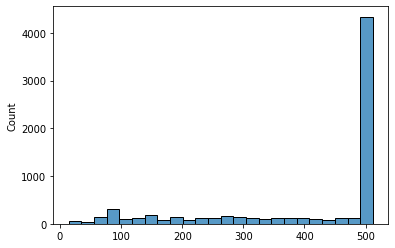

In [ ]:

import seaborn as sn
sn.histplot(tokenized_dataset_shift['test']['token_count'])

In [ ]:

# Removing the overly long ones (so as to see how big of a problem this is)

untruncated_train_df = tokenized_dataset_shift['train']\
  .to_pandas()\
  .query('not is_max_count')

train_dataset = datasets.Dataset.from_pandas(untruncated_train_df)
train_dataset = train_dataset.class_encode_column('label')


untruncated_test_df = tokenized_dataset_shift['test']\
  .to_pandas()\
  .query('not is_max_count')

test_dataset = datasets.Dataset.from_pandas(untruncated_test_df)
test_dataset = test_dataset.class_encode_column('label')


Casting to class labels:   0%|          | 0/12 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/2 [00:00<?, ?ba/s]

Casting to class labels:   0%|          | 0/3 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
train_dataset.features


{'__index_level_0__': Value(dtype='int64', id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'is_max_count': Value(dtype='bool', id=None),
 'job_id': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=5, names=['Days', 'Evenings', 'Flexible', 'Nights', 'Not Listed'], id=None),
 'text': Value(dtype='string', id=None),
 'token_count': Value(dtype='int64', id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
# To debug on small data

#small_train_dataset = tokenized_dataset_shift["train"].shuffle(seed=42).select(range(1000))
#small_eval_dataset = tokenized_dataset_shift["test"].shuffle(seed=42).select(range(1000))


In [ ]:
id2label_shifts = {i: name for i, name in enumerate(train_dataset.features['label'].names)}
label2id_shifts = {name: i for i, name in enumerate(train_dataset.features['label'].names)}

# Build the training pipeline

In [ ]:

len(set(tokenized_dataset_shift['test']['label']))

5

In [ ]:
from transformers import AutoModelForSequenceClassification

# TODO would be convenient to save this with id2label and label2id
model_shifts = AutoModelForSequenceClassification\
  .from_pretrained("bert-base-cased",
                    num_labels=len(set(tokenized_dataset_shift['test']['label'])),
                    id2label=id2label_shifts,
                    label2id=label2id_shifts)\
  .to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir=transformer_dir)


In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)



In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir=transformer_dir, evaluation_strategy="epoch")


trainer_shifts = Trainer(
    model=model_shifts,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)


In [ ]:
trainer_shifts.train()


The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_count, text, __index_level_0__, job_id, is_max_count. If token_count, text, __index_level_0__, job_id, is_max_count are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 11807
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4428


Epoch,Training Loss,Validation Loss,Accuracy
1,0.712000,0.597207,0.778472
2,0.555900,0.539130,0.800347
3,0.457200,0.554362,0.811111


Saving model checkpoint to /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-500
Configuration saved in /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-1000
Configuration saved in /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: token_count, text, __index_level_0__, job_id, is_max_count. If token_count, text, __index_level_0__, job_id, is_max_count are not expected by `BertForSequenceClassification.forward`, 

TrainOutput(global_step=4428, training_loss=0.6047232988834812, metrics={'train_runtime': 2404.6638, 'train_samples_per_second': 14.73, 'train_steps_per_second': 1.841, 'total_flos': 9319907724217344.0, 'train_loss': 0.6047232988834812, 'epoch': 3.0})

## Loading saved model

In [ ]:
model_file_to_load = '/content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-4000'

In [ ]:
import json

with open(f'{model_file_to_load}/config.json', 'r') as config_handle:
  fitted_model_config = json.load(config_handle)

fitted_model_config

{'_name_or_path': 'bert-base-cased',
 'architectures': ['BertForSequenceClassification'],
 'attention_probs_dropout_prob': 0.1,
 'classifier_dropout': None,
 'gradient_checkpointing': False,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'id2label': {'0': 'Days',
  '1': 'Evenings',
  '2': 'Flexible',
  '3': 'Nights',
  '4': 'Not Listed'},
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'label2id': {'Days': 0,
  'Evenings': 1,
  'Flexible': 2,
  'Nights': 3,
  'Not Listed': 4},
 'layer_norm_eps': 1e-12,
 'max_position_embeddings': 512,
 'model_type': 'bert',
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'pad_token_id': 0,
 'position_embedding_type': 'absolute',
 'problem_type': 'single_label_classification',
 'torch_dtype': 'float32',
 'transformers_version': '4.21.0',
 'type_vocab_size': 2,
 'use_cache': True,
 'vocab_size': 28996}

In [ ]:

from transformers import AutoModelForSequenceClassification
model_shifts = AutoModelForSequenceClassification\
  .from_pretrained(model_file_to_load)



loading configuration file /content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-4000/config.json
Model config BertConfig {
  "_name_or_path": "/content/drive/MyDrive/Vivian Project/Transformer Fine Tuning/checkpoint-4000",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Days",
    "1": "Evenings",
    "2": "Flexible",
    "3": "Nights",
    "4": "Not Listed"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Days": 0,
    "Evenings": 1,
    "Flexible": 2,
    "Nights": 3,
    "Not Listed": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "sin

In [ ]:
from transformers import pipeline
categorizer_shifts = pipeline(task="text-classification", model=model_shifts, tokenizer=tokenizer, top_k=5)


In [ ]:
categorizer_shifts('the night shift')

[[{'label': 'Nights', 'score': 0.9043019413948059},
  {'label': 'Evenings', 'score': 0.02984244003891945},
  {'label': 'Flexible', 'score': 0.027795588597655296},
  {'label': 'Days', 'score': 0.02425479143857956},
  {'label': 'Not Listed', 'score': 0.013805285096168518}]]

In [ ]:

categorizer_shifts('irrelevant text')

[[{'label': 'Not Listed', 'score': 0.7097378969192505},
  {'label': 'Flexible', 'score': 0.20158188045024872},
  {'label': 'Days', 'score': 0.061259422451257706},
  {'label': 'Nights', 'score': 0.017062347382307053},
  {'label': 'Evenings', 'score': 0.01035845372825861}]]

In [ ]:

categorizer_shifts('the night shift')

[[{'label': 'Nights', 'score': 0.9043019413948059},
  {'label': 'Evenings', 'score': 0.02984244003891945},
  {'label': 'Flexible', 'score': 0.027795588597655296},
  {'label': 'Days', 'score': 0.02425479143857956},
  {'label': 'Not Listed', 'score': 0.013805285096168518}]]

In [ ]:
categorizer_shifts('this job has flexible hours')

[[{'label': 'Flexible', 'score': 0.5746778249740601},
  {'label': 'Not Listed', 'score': 0.34680166840553284},
  {'label': 'Days', 'score': 0.046153392642736435},
  {'label': 'Nights', 'score': 0.02256045863032341},
  {'label': 'Evenings', 'score': 0.009806608781218529}]]

In [ ]:
categorizer_shifts('Work is in the day time')

[[{'label': 'Days', 'score': 0.9595456123352051},
  {'label': 'Flexible', 'score': 0.021559523418545723},
  {'label': 'Not Listed', 'score': 0.01048885378986597},
  {'label': 'Nights', 'score': 0.006044239737093449},
  {'label': 'Evenings', 'score': 0.002361886901780963}]]

In [ ]:
categorizer_shifts('Work hours are 5p-10p')

[[{'label': 'Evenings', 'score': 0.9722661972045898},
  {'label': 'Days', 'score': 0.011288217268884182},
  {'label': 'Flexible', 'score': 0.008173220790922642},
  {'label': 'Nights', 'score': 0.0071233659982681274},
  {'label': 'Not Listed', 'score': 0.0011488451855257154}]]

In [ ]:
categorizer_shifts('Work hours are 9a-5p')

[[{'label': 'Days', 'score': 0.9206545948982239},
  {'label': 'Flexible', 'score': 0.05268487334251404},
  {'label': 'Evenings', 'score': 0.010079101659357548},
  {'label': 'Not Listed', 'score': 0.008679519407451153},
  {'label': 'Nights', 'score': 0.007901926524937153}]]

In [ ]:
categorizer_shifts('Work hours are 10p-6a')

[[{'label': 'Evenings', 'score': 0.5608419179916382},
  {'label': 'Nights', 'score': 0.34428682923316956},
  {'label': 'Flexible', 'score': 0.04687580466270447},
  {'label': 'Days', 'score': 0.04176730290055275},
  {'label': 'Not Listed', 'score': 0.006228210404515266}]]

In [ ]:
inputs = tokenizer("Work is in the day time", return_tensors="pt")


In [ ]:
outputs = model_shifts(**inputs)

In [ ]:

outputs

SequenceClassifierOutput([('logits',
                           tensor([[ 3.9461, -2.0609,  0.1505, -1.1212, -0.5700]],
                                  grad_fn=<AddmmBackward0>))])

In [ ]:
%%time

full_dataset_unlabeled = datasets.Dataset.from_pandas(job_descriptions[['title_plus_description']])
full_dataset_unlabeled = full_dataset_unlabeled.rename_column("title_plus_description", "text")
#full_dataset = full_dataset.rename_column("shift", "label")
full_dataset_unlabeled_tokenized = full_dataset_unlabeled.map(preprocess_data, batched=True)


  0%|          | 0/36 [00:00<?, ?ba/s]

CPU times: user 1min 11s, sys: 1.36 s, total: 1min 13s
Wall time: 1min 14s


In [ ]:

tokenized_full_dataset

Dataset({
    features: ['text', 'label', 'job_id', 'input_ids', 'token_type_ids', 'attention_mask', 'token_count', 'is_max_count'],
    num_rows: 35720
})

In [ ]:
%%time

test_args = TrainingArguments(
    output_dir = model_file_to_load,
    do_train = False,
    do_predict = True,
    per_device_eval_batch_size = 8,   
    dataloader_drop_last = False    
)

# TODO Pretty sure the problerm is: it doesn't like the NAN in 'label'. Need to drop those

# init trainer
trainer = Trainer(
              model = model_shifts, 
              args = test_args)

preds_shift_all = trainer.predict(full_dataset_unlabeled_tokenized)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: is_max_count, text, job_id, token_count. If is_max_count, text, job_id, token_count are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 35720
  Batch size = 8


CPU times: user 10min 53s, sys: 3.36 s, total: 10min 56s
Wall time: 10min 56s


In [ ]:

id2label

{0: 'Days', 1: 'Evenings', 2: 'Flexible', 3: 'Nights', 4: 'Not Listed'}

In [ ]:
bert_ft_shift_preds = pd.DataFrame(preds_shift_all.predictions, columns=[f'bert_ft_shift_pred_{id2label[i]}' for i in range(5)], index=job_descriptions.index)

bert_ft_shift_preds.to_pickle(f'{transformer_dir}/bert_ft_shift_preds.pickle')

In [ ]:
 def interpret_prediction(row):
  ret = {val2id[x['label']]: x['score'] for x in row}
  ret['predicted_label'] = val2id[row[0]['label']]
  ret['predicted_val'] = row[0]['score']
  return ret


test_preds_df = pd.DataFrame(interpret_prediction(row) for row in test_preds)

In [ ]:
test_preds_df.index = test_df.index[:predict_first_n]
test_preds_df['label'] = test_df.iloc[:predict_first_n]['label']


In [ ]:
test_preds_df.query('label != predicted_label')

,0,3,2,1,4,predicted_label,predicted_val,label
job_id,,,,,,,,
pm-healthcaresource-com_www-saintfrancis-com-69415,0.261025,0.402854,0.277441,0.040018,0.018662,3,0.402854,0
ziprecruiter-appcast_agency_ascension_cpc33aef51633aef516-28494015982,0.073063,0.016293,0.247843,0.006882,0.655920,4,0.655920,2
careersbaptisthealthnet-BAHEUS117735ENUS,0.002143,0.001302,0.990333,0.000894,0.005327,2,0.990333,0
ziprecruiter-appcastapiaverageperformanceandmonthstartcnadrifthosted_2084444fd4b3d8-12509_a4d279430fcef88d9fc93f9a5a9e0242,0.009317,0.001888,0.037220,0.000957,0.950617,4,0.950617,2
mercy-MEHEUS870103EXTERNALENUS,0.826871,0.036568,0.084900,0.013059,0.038603,0,0.826871,3
pm-healthcaresource-com_www-saintfrancis-com-67439,0.270019,0.373218,0.294542,0.042394,0.019827,3,0.373218,0


In [ ]:

print(test_df.loc['pm-healthcaresource-com_www-saintfrancis-com-69415']['text'])

# Hm so model predicted 3 == nights, label is 0 == days, and when I read this seems to me this is 4: not listed…
# Seems like the info really isn't here, biggest mystery is why the model thinks it's days and gave low weight to not listed.

title: Registered Nurse I - Tulsa, OK
        description: Job Summary: The Clinical Nurse I assesses, plans, implements and evaluates
nursing care, utilizing the nursing process in accordance with hospital
standards and unit policies/procedures for the purpose of monitoring and
evaluating patient functional status.  
  
Education: Completion of a state approved Registered Nurse program.  
  
Licensure, Registration and/or Certification: Valid State of Oklahoma
Registered Nurse License.  
  
Work Experience: 0 - 6 months related experience.  
  
Knowledge, Skills and Abilities: Working knowledge of general disease state
management processes, bio-psychosocial model, and clinical pathways. Effective
interpersonal, written, and oral communication skills. Ability to organize and
prioritize work in an effective and efficient manner. Ability to be detail
oriented as required in the examination of clinical and numerical data.


In [ ]:
# So in this situation model said 4 (==not listed) but label says 2 (flexible)
# …I'd go with the model. Nothing explicitly says it's flexible. Must be world knowledge?

print(test_df.loc['ziprecruiter-appcast_agency_ascension_cpc33aef51633aef516-28494015982']['text'])


title: CNA Certified Nursing Assistant - Premium Pay!!! - Ponca City, OK, USA
        description: SHORT TERM OPTION **CNA** Via Christi Village Ponca City , an Ascension Living
community , now offers ... Reports findings or changes in physical, mental and
emotional conditions to **nursing** staff


In [ ]:
print(job_descriptions.set_index('job_id').loc['careersbaptisthealthnet-BAHEUS117735ENUS', ['discipline', 'employment_type', 'shift']])
print(test_df.loc['careersbaptisthealthnet-BAHEUS117735ENUS']['text'])

# Model was super sure this one was 2 (flexible), humans labeled it 0 (day)
# Again this is nuts. I'd say 4 (not listed) … maybe where it says "varies" that's a slot that for time?
# …also is pool sterilization a relevant job??

discipline         Allied Health Professional
employment_type                      Per Diem
shift                                    Days
Name: careersbaptisthealthnet-BAHEUS117735ENUS, dtype: object
title: Pool Sterilization Tech, Central Sterilization, Per Diem, Varies - Boca Raton, Florida
        description: 

##

  

Baptist Health has a commitment to strengthening the compassionate care we
provide. With the addition of Boca Raton Regional Hospital, Baptist Health is
able to provide the Palm Beach community expanded access to healthcare
services.  
  
Boca Raton Regional Hospital is an advanced tertiary medical center with 400
beds and is a recognized leader in Cardiovascular Care, Oncology, Women's
Health, Orthopedics, Emergency Medicine and the Neurosciences, all of which
offer state-of-the-art diagnostic and imaging capabilities. The Hospital is
now a part of Baptist Health South Florida is the region's largest not-for-
profit healthcare organization with more than 23,000 empl

In [ ]:
job_descriptions.set_index('job_id').loc['careersbaptisthealthnet-BAHEUS117735ENUS']


description               <h2></h2><br><font face="Arial" size="3"><p st...
job_title                 Pool Sterilization Tech, Central Sterilization...
employment_type                                                    Per Diem
shift                                                                  Days
discipline                                       Allied Health Professional
specialty                                     Sterile Processing Technician
title_plus_description    title: Pool Sterilization Tech, Central Steril...
Name: careersbaptisthealthnet-BAHEUS117735ENUS, dtype: object

In [ ]:
print(job_descriptions.set_index('job_id').loc['ziprecruiter-appcastapiaverageperformanceandmonthstartcnadrifthosted_2084444fd4b3d8-12509_a4d279430fcef88d9fc93f9a5a9e0242', ['discipline', 'employment_type', 'shift']])
print(test_df.loc['ziprecruiter-appcastapiaverageperformanceandmonthstartcnadrifthosted_2084444fd4b3d8-12509_a4d279430fcef88d9fc93f9a5a9e0242']['text'])

# Model was super sure this one was 4 (not listed), humans labeled it flexible
# …again model was definitely right

discipline               CNA
employment_type    Permanent
shift               Flexible
Name: ziprecruiter-appcastapiaverageperformanceandmonthstartcnadrifthosted_2084444fd4b3d8-12509_a4d279430fcef88d9fc93f9a5a9e0242, dtype: object
title: Certified Nursing Assistant (CNA) ***$3,000 Sign-On Bonus*** - Brooksville, FL, USA
        description: Join our amazingly warm and compassionate team at our skilled **nursing**
facility. We are hiring a **CNA** to join our team of passionate healthcare
professionals. You will work directly with residents who ...


In [ ]:
print(job_descriptions.set_index('job_id').loc['mercy-MEHEUS870103EXTERNALENUS', ['discipline', 'employment_type', 'shift']])
print(test_df.loc['mercy-MEHEUS870103EXTERNALENUS']['text'])

# Model labeled this one was 0 (day), medium high confidence. humans labeled it nights
# …again it seems clearly not listed? Honestly more annoying that the model says day

discipline             RN
employment_type    Travel
shift              Nights
Name: mercy-MEHEUS870103EXTERNALENUS, dtype: object
title: Registered Nurse - Oklahoma City, Oklahoma
        description: 

**Temporary 13 Week Assignment. Full-time, 36hrs per week. $75/hr.**

**We’re a Little Different**

Our mission is clear. We bring to life a healing ministry through our
compassionate care and exceptional service.  
  
At Mercy, we believe in _careers_ that match the unique gifts of unique
individuals – _careers_ that not only make the most of your skills and
talents, but also your heart. Join us and discover why Modern Healthcare
Magazine named us in its “Top 100 Places to Work.”

  
 **Qualifications:**

Licensure: Current Oklahoma License  
Certifications: Current BLS certification required before assigned to care for
patients independently. Current NRP Certification required before assigned to
care for patients independently.  
Other: Completes Hospital and nursing competency within

In [ ]:

print(job_descriptions.set_index('job_id').loc['pm-healthcaresource-com_www-saintfrancis-com-67439', ['discipline', 'employment_type', 'shift']])
print(test_df.loc['pm-healthcaresource-com_www-saintfrancis-com-67439']['text'])


# Model called this one night with super low confidence, it's supposed to be day,
# again I have no idea how the text implies day or why the model would say night.

discipline                RN
employment_type    Permanent
shift                   Days
Name: pm-healthcaresource-com_www-saintfrancis-com-67439, dtype: object
title: Clinical Nurse I - Tulsa, OK
        description: Job Summary: The Clinical Nurse I assesses, plans, implements and evaluates
nursing care, utilizing the nursing process in accordance with hospital
standards and unit policies/procedures for the purpose of monitoring and
evaluating patient functional status.  
  
Education: Completion of a state approved Registered Nurse program.  
  
Licensure, Registration and/or Certification: Valid State of Oklahoma
Registered Nurse License.  
  
Work Experience: 0 - 6 months related experience.  
  
Knowledge, Skills and Abilities: Working knowledge of general disease state
management processes, bio-psychosocial model, and clinical pathways. Effective
interpersonal, written, and oral communication skills. Ability to organize and
prioritize work in an effective and efficient manner. Abi

In [ ]:

for thresh in [0, .3, .5, .7, .8, .9, .95, .98]:
  rows = test_preds_df.query(f'predicted_val > {thresh}')
  size = rows.shape[0]
  proportion = rows.shape[0] / test_preds_df.shape[0]
  accuracy = np.mean(rows.apply(lambda x: x['label'] == x['predicted_label'], axis=1))
  print(f'Threshhold: {thresh} Proportion: {proportion} Accuracy: {accuracy}')



Threshhold: 0 Proportion: 1.0 Accuracy: 0.885
Threshhold: 0.3 Proportion: 1.0 Accuracy: 0.885
Threshhold: 0.5 Proportion: 0.955 Accuracy: 0.9057591623036649
Threshhold: 0.7 Proportion: 0.835 Accuracy: 0.9341317365269461
Threshhold: 0.8 Proportion: 0.775 Accuracy: 0.9548387096774194
Threshhold: 0.9 Proportion: 0.705 Accuracy: 0.9574468085106383
Threshhold: 0.95 Proportion: 0.66 Accuracy: 0.9696969696969697
Threshhold: 0.98 Proportion: 0.495 Accuracy: 0.9797979797979798


In [ ]:
np.mean(test_preds_df.query('predicted_val > .9').apply(lambda x: x['label'] == x['predicted_label'], axis=1))

0.9428571428571428